<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#TOI-216:-TTV-test-fit" data-toc-modified-id="TOI-216:-TTV-test-fit-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>TOI-216: TTV test fit</a></span><ul class="toc-item"><li><span><a href="#download-data-of-first-2-sectors" data-toc-modified-id="download-data-of-first-2-sectors-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>download data of first 2 sectors</a></span></li><li><span><a href="#fit" data-toc-modified-id="fit-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>fit</a></span></li><li><span><a href="#save-config-file" data-toc-modified-id="save-config-file-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>save config file</a></span></li><li><span><a href="#Sampling" data-toc-modified-id="Sampling-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Sampling</a></span></li><li><span><a href="#get-times-for-each-planet" data-toc-modified-id="get-times-for-each-planet-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>get times for each planet</a></span></li></ul></li></ul></div>

In [1]:
from CONAN3.get_files import get_TESS_data, get_parameters
import numpy as np
import matplotlib.pyplot as plt
import CONAN3
CONAN3.__version__

'3.2.0'

## TOI-216: TTV test fit

### download data of first 2 sectors

In [ ]:

df = get_TESS_data("TOI-216")
df.search(author="SPOC") 

In [ ]:
df.download(sectors=[1,2],author="SPOC", select_flux="pdcsap_flux",quality_bitmask='hardest')

In [ ]:
df.scatter()

In [ ]:
df.save_CONAN_lcfile(bjd_ref = 2457000, folder="TOI-216")

### fit

In [2]:
lc_list = ["TOI-216_S1.dat","TOI-216_S2.dat"]
lc_obj = CONAN3.load_lightcurves(lc_list,"TOI-216/",nplanet=2)
lc_obj

# ============ Input lightcurves, filters baseline function =======================================================
name           filt 𝜆_𝜇m |s_samp  clip    scl_col |col0 col3 col4 col5 col6 col7 col8|sin id GP spline_config  
TOI-216_S1.dat V    0.6  |None    None    None    |   0    0    0    0    0    0    0|  0  1 n  None           
TOI-216_S2.dat V    0.6  |None    None    None    |   0    0    0    0    0    0    0|  0  2 n  None           


lightcurves from filepath: TOI-216/
2 transiting planet(s)
Order of unique filters: ['V']

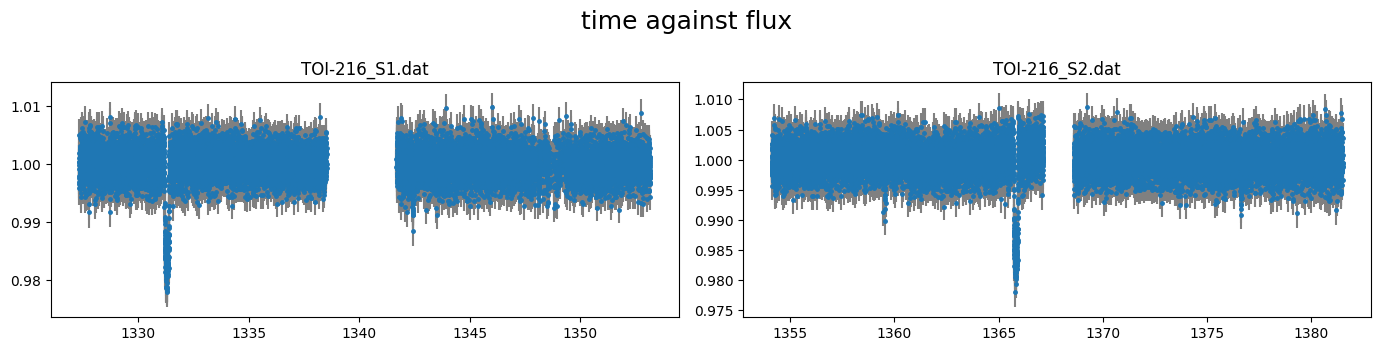

In [3]:
lc_obj.plot()

In [5]:
sys_pars = get_parameters(planet_name="TOI-216")

Loading parameters from cache ...


For multiplanet system, the transit model has to be parameterized by `rho_star` to reduce the number of free paramters (as opposed to fitting `Duration` for each planet's transit)

In [7]:
P     = [17.089, 34.556]    #planet b and c
t_ref = [1325.3270, 1331.28531]

#P and t0 need to be fixed for TTV fit
#make a quick fit with most parameters fixed

lc_obj.planet_parameters(rho_star    = sys_pars["star"]["density"],
                         RpRs        = [0.0833,0.1235],
                         Period      = P, 
                         T_0         = t_ref,
                         Impact_para = [0.948,0.15])

# ============ Planet parameters (Transit and RV) setup ========================================================== 
name                	fit 	prior                              	note
[rho_star]/Duration 	y   	N(2.38,0.1)                        	#choice in []|unit(gcm^-3/days)
------------
RpRs_1              	n   	F(0.0833)                          	#range[-0.5,0.5]
Impact_para_1       	n   	F(0.948)                           	#range[0,2]
T_0_1               	n   	F(1325.327)                        	#unit(days)
Period_1            	n   	F(17.089)                          	#range[0,inf]days
Eccentricity_1      	n   	F(0)                               	#range[0,1]
omega_1             	n   	F(90)                              	#range[0,360]deg
K_1                 	n   	F(0)                               	#unit(same as RVdata)
------------
RpRs_2              	n   	F(0.1235)                          	#range[-0.5,0.5]
Impact_para_2       	n   	F(0.15)                            	#range[0,2]


In [8]:
lc_obj.limb_darkening(q1=0.44, q2=0.24)

# ============ Limb darkening setup ============================================================================= 
filters	fit	q_1              	q_2              
V      	n  	F(0.44)          	F(0.24)          


calling the `.transit_timing_variation()` function with `ttvs='y'` uses the **T_0** and **Period** values set in `.planet_parameters()` to search for transits in the data assuming a linear ephemeris. 

The `print_linear_eph` and `show_plot` arguments provides a print out and plot of the identified linear ephemeris transit times

`dt` is the prior that defines the extent of deviation from linear ephemeris for each transit. Default is **U(-0.125,0,0.125)** indicating a uniform prior ranging between 3hrs before and after the expected linear ephemeris transit. **N(0,0.125)** is a normal prior around the expected transit time

# ============ TTV setup ========================================================================================
Fit_TTVs	dt_priors(deviation from linear T0)	transit_baseline[P] 
y       	N(0,0.125)                         	0.2500

======(linear ephemeris estimate)===============
label               	T0s (ordered)   
ttv00-lc1-T0_pl2    	1331.28531000
ttv01-lc1-T0_pl1    	1342.41600000
ttv02-lc2-T0_pl1    	1359.50500000
ttv03-lc2-T0_pl2    	1365.84131000
ttv04-lc2-T0_pl1    	1376.59400000


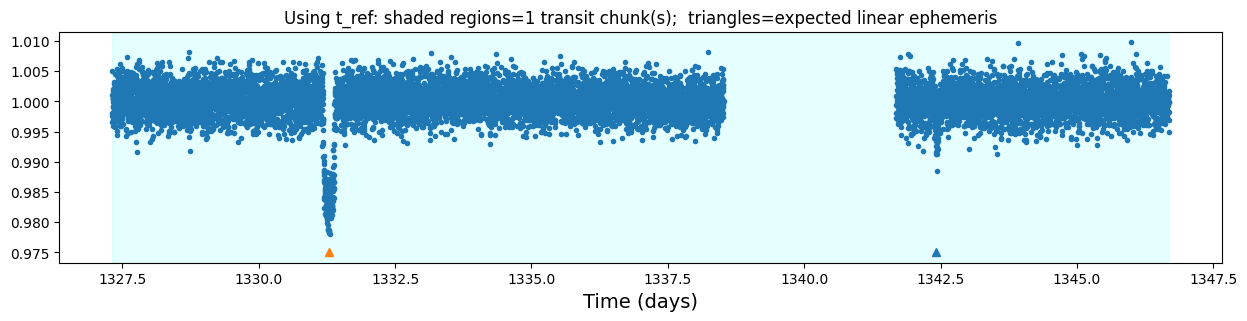

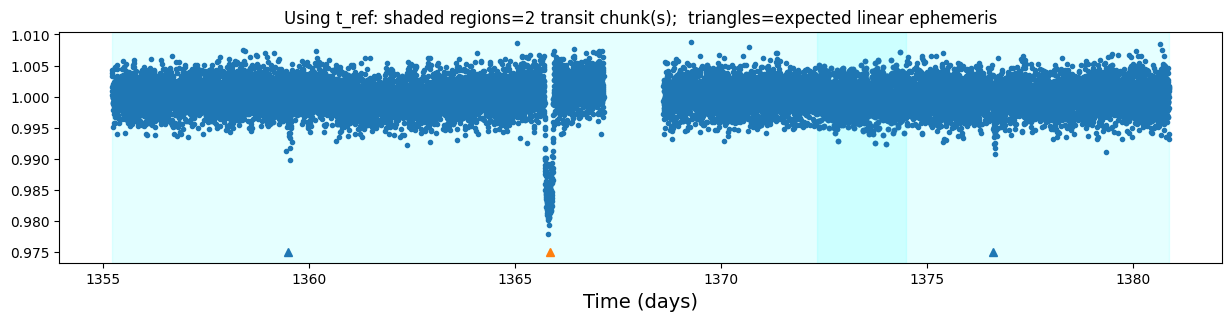

In [9]:
lc_obj.transit_timing_variation(ttvs="y", dt=(0,0.125), baseline_amount=0.25,
                                show_plot=True, print_linear_eph=True)

run a quick fit. with no baseline model

In [10]:
fit_obj = CONAN3.fit_setup(apply_LCjitter="n")
fit_obj.sampling(n_cpus=10,n_live=150)

# ============ Stellar input properties ======================================================================
# parameter     value 
Radius_[Rsun]  N(1.000,0.010)
Mass_[Msun]    N(1.000,0.010)
Input_method:[R+rho(Rrho), M+rho(Mrho)]: Rrho
# ============ FIT setup =====================================================================================
Number_steps                              2000 
Number_chains                             64 
Number_of_processes                       10 
Burnin_length                             500 
n_live                                    150 
force_nlive                               False 
d_logz                                    0.1 
Sampler(emcee/dynesty)                    dynesty 
emcee_move(stretch/demc/snooker)          stretch 
nested_sampling(static/dynamic[pfrac])    static 
leastsq_for_basepar(y/n)                  n 
apply_LCjitter(y/n)                       n 
apply_RVjitter(y/n)                       y 
LCjitter_loglims(auto/[lo,hi])  

### save config file

In [11]:
CONAN3.create_configfile(lc_obj, None, fit_obj,
                         filename='TOI216_ttvconfig.dat')

configuration file saved as TOI216_ttvconfig.dat


In [12]:
import CONAN3
lc_obj, rv_obj, fit_obj = CONAN3.load_configfile('TOI216_ttvconfig.dat')

lc_list is None: No lightcurve to clip outliers.


### Sampling

In [13]:
result = CONAN3.run_fit(lc_obj,None,fit_obj, out_folder="result_TOI-216", rerun_result=True)

Fit result already exists in this folder: result_TOI-216.
Rerunning with saved posterior chains to generate plots and files...

CONAN fit launched!!!

Setting up photometry arrays ...
Setting up RV arrays ...
Plotting prior distributions

Plotting initial guess
---------------------------

============ Samping started ... (using dynesty [static])======================
No of cpus: 10
No of dimensions: 8
fitting parameters:  ['rho_star' 'ttv00-lc1-T0_pl2' 'ttv01-lc1-T0_pl1' 'ttv02-lc2-T0_pl1'
 'ttv03-lc2-T0_pl2' 'ttv04-lc2-T0_pl1' 'lc1_off' 'lc2_off']

Skipping dynesty run. Loading chains from disk

Dynesty chain written to disk as result_TOI-216/chains_dict.pkl. Run `result=CONAN3.load_result()` to load it.

============ Sampling Finished ==============================================

saved 1 corner plot(s) as result_TOI-216/corner_*.png

Plotting output figures
LC1 ...Writing LC output to file: result_TOI-216/TOI-216_S1_lcout.dat
LC2 ...Writing LC output to file: result_TOI-216/TOI-21

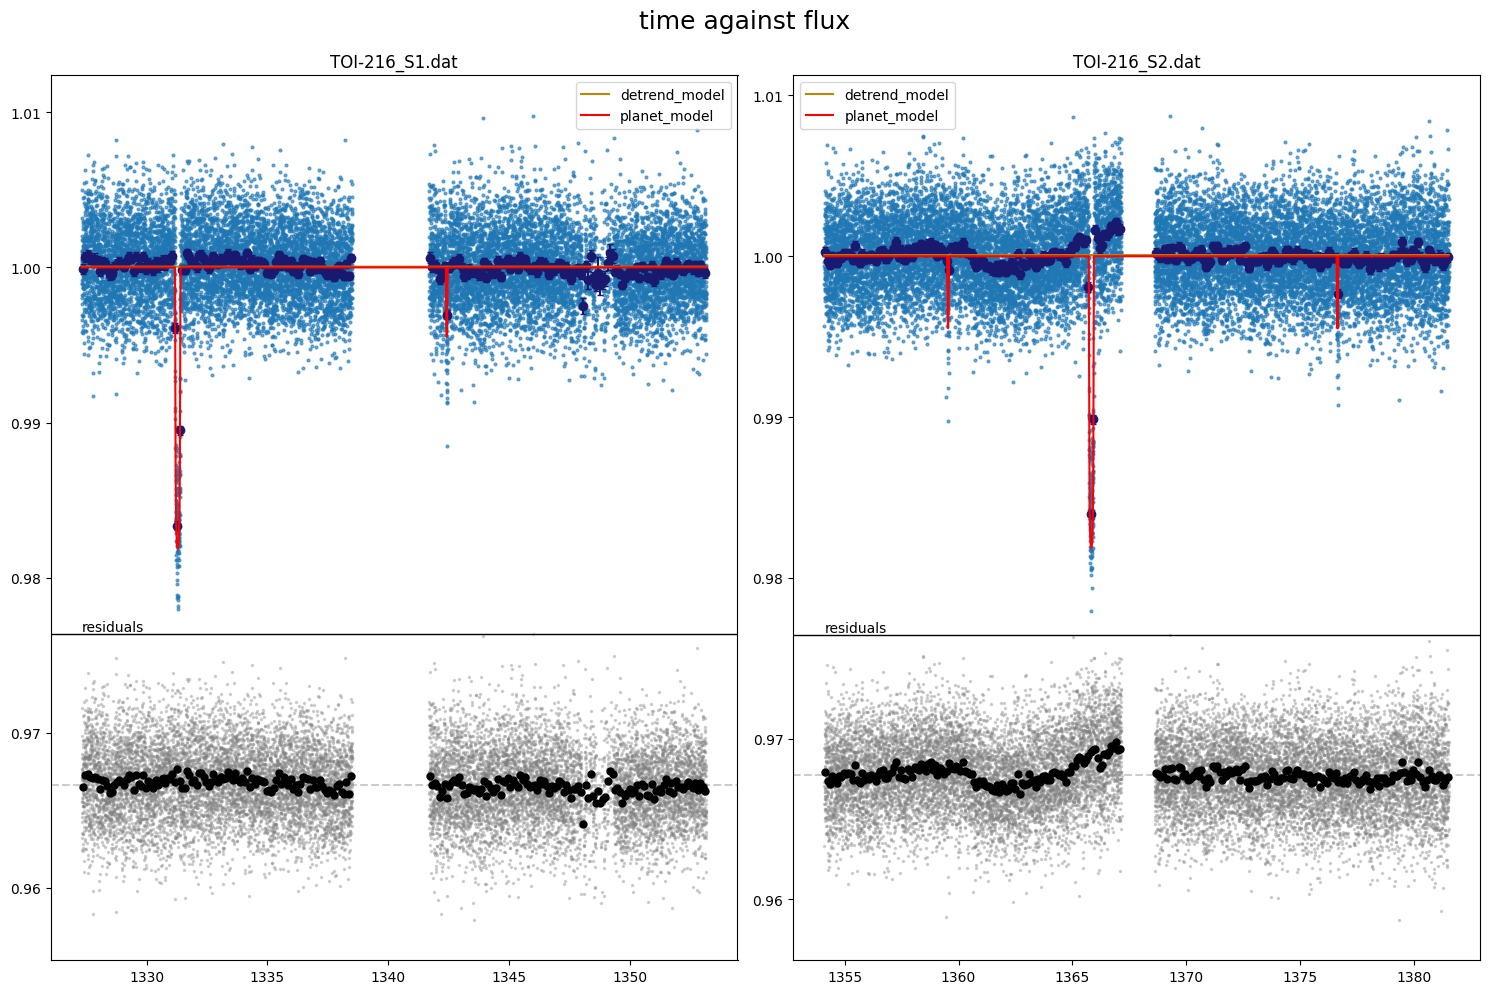

In [17]:
result.lc.plot_bestfit(figsize=(15,10),binsize=0.1);

In [18]:
result.lc.names

['TOI-216_S1.dat', 'TOI-216_S2.dat']

In [19]:
result.params.names

['rho_star',
 'ttv00-lc1-T0_pl2',
 'ttv01-lc1-T0_pl1',
 'ttv02-lc2-T0_pl1',
 'ttv03-lc2-T0_pl2',
 'ttv04-lc2-T0_pl1',
 'lc1_off',
 'lc2_off']

In [29]:
#names of all transit time parameters
all_T0_names = [nm for nm in result.params.names if 'T0_pl' in nm]
print(list(all_T0_names))

['ttv00-lc1-T0_pl2', 'ttv01-lc1-T0_pl1', 'ttv02-lc2-T0_pl1', 'ttv03-lc2-T0_pl2', 'ttv04-lc2-T0_pl1']


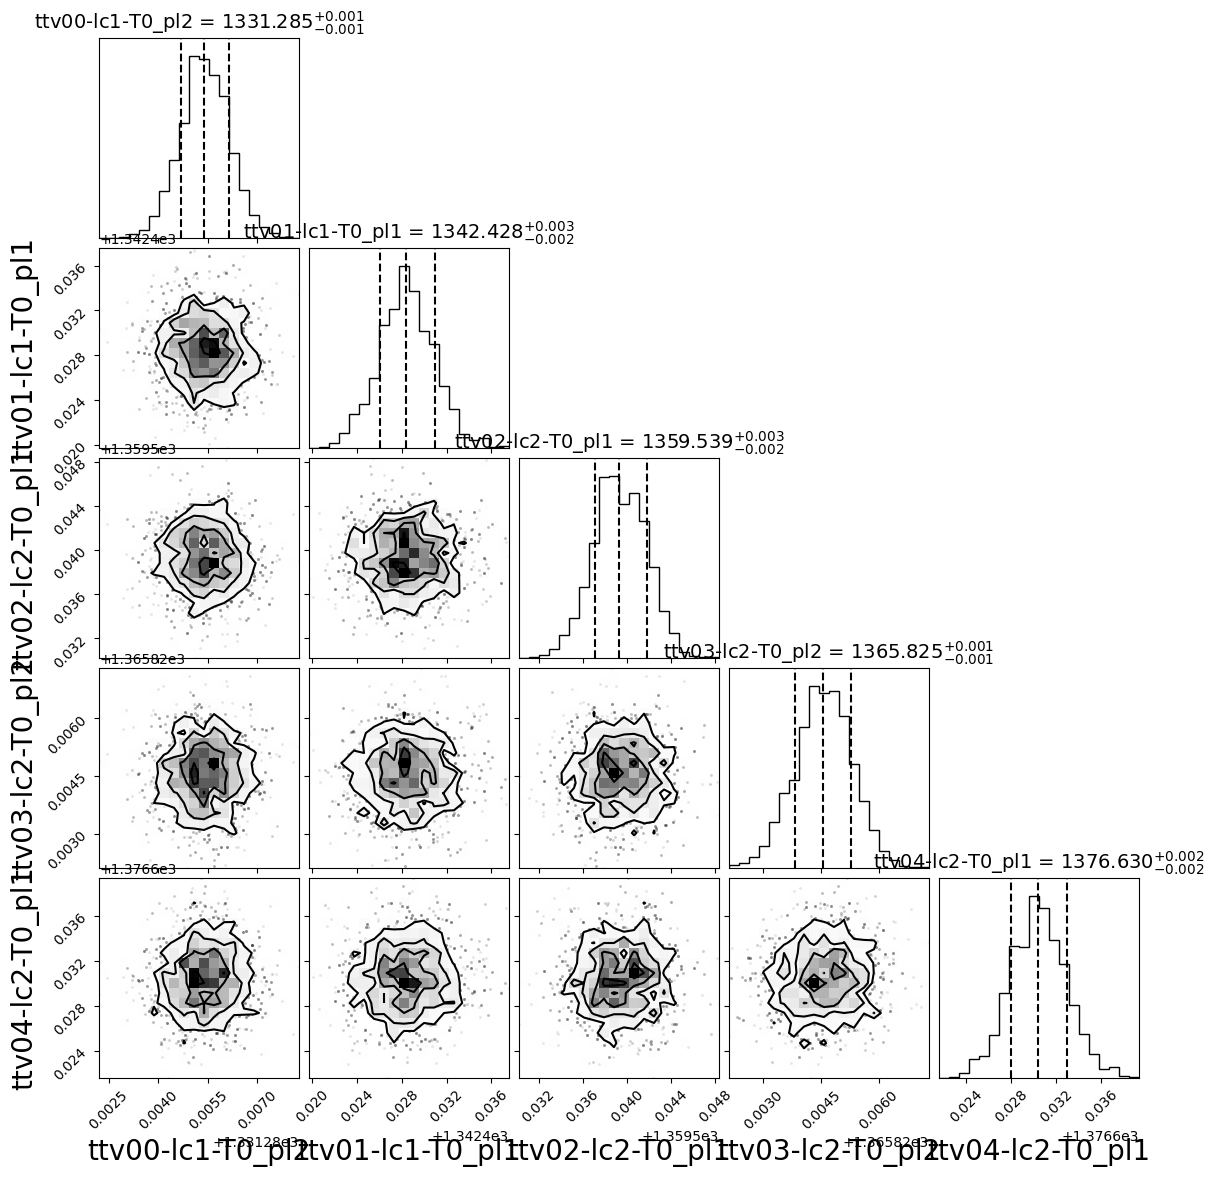

In [32]:
#corner of T0s
fig = result.plot_corner(pars = all_T0_names);

### get times for each planet

In [33]:
# linear ephemeris computed before the fit
lin_T0 = lc_obj._ttvs.lin_eph
lin_T0

{'ttv00-lc1-T0_pl2': 1331.28531,
 'ttv01-lc1-T0_pl1': 1342.416,
 'ttv02-lc2-T0_pl1': 1359.505,
 'ttv03-lc2-T0_pl2': 1365.84131,
 'ttv04-lc2-T0_pl1': 1376.594}

In [34]:
#T0s from the TTV fit

In [41]:
T0_p1_names = [nm for nm in result.params.names if 'T0_pl1' in nm]
print(f"{T0_p2_names = }")

lin_T0_p1 = np.array([lin_T0[nm] for nm in T0_p1_names])

fit_T0_p1     = np.array([np.median(result._chains[nm]) for nm in T0_p1_names])
fit_T0_p1_unc = np.array([np.std(result._chains[nm]) for nm in T0_p1_names])


T0_p2_names = ['ttv00-lc1-T0_pl2', 'ttv03-lc2-T0_pl2']


In [42]:
T0_p2_names = [nm for nm in result.params.names if 'T0_pl2' in nm]
print(f"{T0_p2_names = }")

lin_T0_p2 = np.array([lin_T0[nm] for nm in T0_p2_names])

fit_T0_p2     = np.array([np.median(result._chains[nm]) for nm in T0_p2_names])
fit_T0_p2_unc = np.array([np.std(result._chains[nm]) for nm in T0_p2_names])

T0_p2_names = ['ttv00-lc1-T0_pl2', 'ttv03-lc2-T0_pl2']


In [43]:
# make ttv plot

<ErrorbarContainer object of 3 artists>

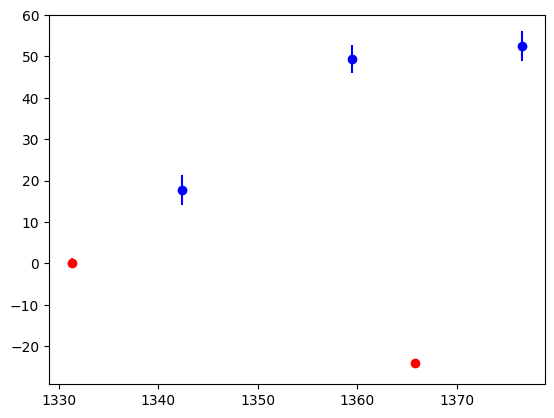

In [44]:
plt.errorbar(lin_T0_p1, (fit_T0_p1 - lin_T0_p1)*24*60, fit_T0_p1_unc*24*60, fmt="bo" )
plt.errorbar(lin_T0_p2, (fit_T0_p2 - lin_T0_p2)*24*60, fit_T0_p2_unc*24*60, fmt="ro" )

EXERCISE: this notebook needs to be improved, including all sectors used in the kipping paper, with GP detrending and fitting the transit parameters.